In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
dataset_dir = '/kaggle/input/plants/train'

In [3]:
input_shape = (224, 224, 3)
batch_size = 32
epochs = 100
initial_lr = 0.001

data_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [4]:
train_dataset = data_generator.flow_from_directory(
    dataset_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_dataset = data_generator.flow_from_directory(
    dataset_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [5]:
num_classes = len(train_dataset.class_indices)
print("Number of classes:", num_classes)
class_names = list(train_dataset.class_indices.keys())
print("Class names:", class_names)

Number of classes: 10
Class names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [6]:
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [8]:
checkpoint_callback = ModelCheckpoint(
    'model_best.keras', monitor='val_loss', save_best_only=True, verbose=1
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)
csv_logger = CSVLogger('training_log.csv')

In [9]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback, csv_logger]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733123489.814776     112 service.cc:145] XLA service 0x5895ea78df90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733123489.814831     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733123489.814836     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 1:13:36 18s/step - accuracy: 0.0938 - loss: 3.9388

I0000 00:00:1733123498.937272     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.4231 - loss: 1.9369
Epoch 1: val_loss improved from inf to 0.67874, saving model to model_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 152s 538ms/step - accuracy: 0.4241 - loss: 1.9329 - val_accuracy: 0.7805 - val_loss: 0.6787
Epoch 2/100
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6849 - loss: 0.9435
Epoch 2: val_loss improved from 0.67874 to 0.54955, saving model to model_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 110s 430ms/step - accuracy: 0.6850 - loss: 0.9432 - val_accuracy: 0.8245 - val_loss: 0.5495
Epoch 3/100
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7219 - loss: 0.8258
Epoch 3: val_loss improved from 0.54955 to 0.49662, saving model to model_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 110s 429ms/step - accuracy: 0.7219 - loss: 0.8257 - val_accuracy: 0.8385 - val_loss: 0.4966
Epoch 4/100
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7415 - loss: 0.7600
Epoch 4: val_loss improved from 0.49662 to

63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 372ms/step

Confusion Matrix:
 [[24 19 22 29 19 22 12 16 17 20]
 [20 19 21 16 22 17 22 21 25 17]
 [24 15 22 17 29 19 20 17 18 19]
 [19 21 15 26 19 20 14 18 25 23]
 [17 15 14 22 23 17 24 23 24 21]
 [24 19 19 21 15 16 27 25 21 13]
 [16 23 18 21 16 26 15 20 19 26]
 [15 19 20 23 20 14 21 25 22 21]
 [19 17 14 13 16 35 17 23 15 31]
 [28 19 17 23 23 19 26 11 21 13]]

Classification Report:
                                                precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.12      0.12      0.12       200
                        Tomato___Early_blight       0.10      0.10      0.10       200
                         Tomato___Late_blight       0.12      0.11      0.12       200
                           Tomato___Leaf_Mold       0.12      0.13      0.13       200
                  Tomato___Septoria_leaf_spot       0.11      0.12      0.11       200
Tomato___Spider_mites Two-spotted_spider_mite       0.08   

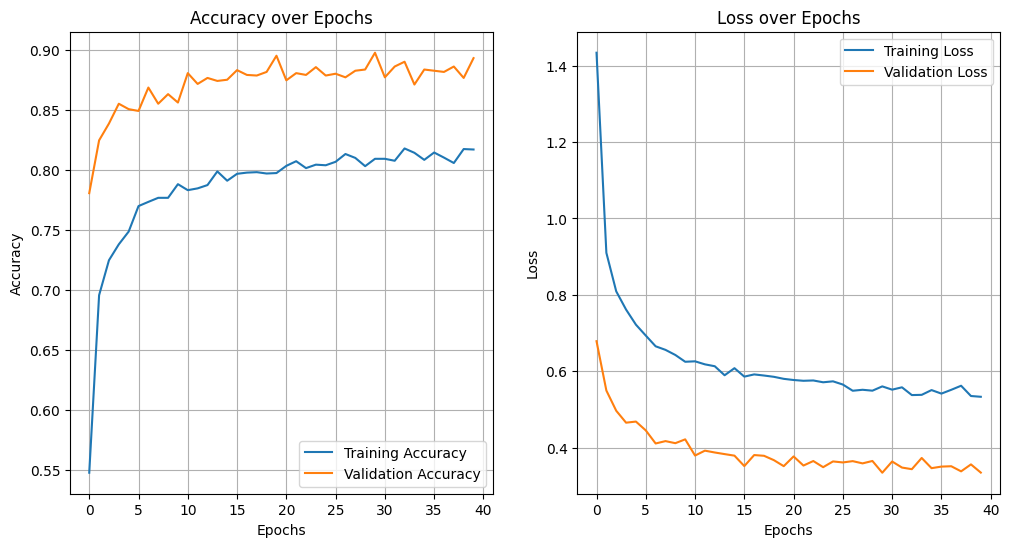

In [10]:
y_true = validation_dataset.classes
y_pred = np.argmax(model.predict(validation_dataset), axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=class_names)

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig('training_validation_accuracy_loss.png')
plt.show()

In [11]:
model.save('mobilenetv2_plant_final.keras')